# __Predicting NTL using DTL__

CNN Model for predicting nighttime lights using daytime images.

## Parameters

In [4]:
PARAM_NAME = "Nbands3_nNtlBins3_minNTLbinCount16861"
#PARAM_NAME = "Nbands3_nNtlBins3_minNTLbinCount100"
YEAR = 2014

In [98]:
#!pip install -U efficientnet
#!pip install pydot
#!pip install graphviz
#!pip install pydotplus

     |████████████████████████████████| 278 kB 7.1 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=7547bf9c1127a5c5f6d3a2a397aad553f240d6b77a719622aafb9edc2eeb5a64
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1f/5c/ba/f931f74fcac8f48b18ae597279203b1c1f92fc76249c2b6f66
Successfully built pydotplus


## Setup

In [38]:
from numpy.random import seed

import os, datetime
import numpy as np
import pandas as pd
import json

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import tensorflow.keras as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
import efficientnet.keras as efn
from keras.applications.inception_v3 import preprocess_input

import logging, os 
import random
import tensorflow as tf
import matplotlib.pyplot as plt

import boto3
from sagemaker import get_execution_role
from s3fs.core import S3FileSystem 
s3 = S3FileSystem()
role = get_execution_role()

# Set seeds. Note that using a GPU can still introduce randomness.
# (also not taking into account tensorflow randomness)
seed(42)

In [6]:
bucket = 'worldbank-pakistan-data'

#### CNN directry in s3 bucket with data
CNN_DIR = os.path.join('Rus/CNN', PARAM_NAME)
LOCAL_DIR = '/home/ec2-user/SageMaker/'

#### FILES ALREADY CREATED

# JSON file with parameters for CNN
CNN_PARAMS_FILENAME = os.path.join(CNN_DIR, 'CNN_parameters.json')

# Nighttime lights and daytime imagery path (numpy files prepped for CNN)
NTL_FILENAME = os.path.join(CNN_DIR, f'ntl_{str(YEAR)}.npy')
DTL_FILENAME = os.path.join(CNN_DIR, f'dtl_{str(YEAR)}.npy')

#### FILES TO CREATE

# CNN model (h5 file) 
# -- 1. Name
# -- 2. Checkpoint (where to store model locally; cnn model saves best model durig training)
# -- 3. s3 path, where to upload back to s3 bucket
CNN_MODEL_NAME = f'script_CNN_{str(YEAR)}_rus.h5'
CNN_MODEL_CHECKPOINT = os.path.join(LOCAL_DIR, CNN_MODEL_NAME)
CNN_MODEL_S3_PATH = os.path.join(CNN_DIR, CNN_MODEL_NAME)

# CSV file with predicted NTL values from CNN (upload to s3)
PREDICTION_FILENAME = f'cnn_predictions_truth_values_{str(YEAR)}_rus.csv'
#PREDICTION_FILENAME = os.path.join(CNN_DIR, f'cnn_predictions_truth_values_{str(YEAR)}.csv')

## Functions

In [7]:
def normalize(X):
    '''
    Normalizes features.
    '''
    return X.astype('float32') / 255.0

def define_model_imagenet(height, width, channels, num_classes):
    '''
    Defines and compiles CNN model.
    
    Inputs:
        height, width, channels, num_classes (int)
    Returns:
        model (keras.Model object)
    '''

    # https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5
    # https://towardsdatascience.com/cnn-transfer-learning-fine-tuning-9f3e7c5806b2

    #### Base model
    input_shape = (height, width, channels)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    #### Model Customization
    # We take the last layer of our the model and add it to our classifier
    last = base_model.layers[-1].output
    x = Flatten()(last)
    x = Dense(100, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(base_model.input, x)
    # We compile the model
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

def evaluate_model(model, trainX, trainY, testX, testY, CNN_MODEL_CHECKPOINT):
    '''
    Fits model, evaluates model, saves best model over epochs and cross-validations.
    
    Inputs:
        model (CNN model) keras.Model object
        trainX, trainY (numpy.ndarray) 4D array of DTL features and 2D array of targets for training
        testX, testY (numpy.ndarray) 4D array of DTL features and 2D array of targets for testing
        current_kfold (int) iteration in kfold cross-val, default=None for no cross-val
        display_metrics (bool) Default=False
    Returns:
        None
    # https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29
    '''

    # Use early stopping to help with overfitting
    es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=False)

    # Save best model based on accuracy
    mc = ModelCheckpoint(CNN_MODEL_CHECKPOINT, monitor='val_loss', mode='min', 
                         verbose=True, save_best_only=True)

    # Fit model
    model.fit(trainX, trainY, 
            epochs=100, 
            batch_size=500, 
            validation_data=(testX, testY), 
            callbacks=[es, mc], 
            verbose=False)

    # Show accuracy
    loss, accuracy = model.evaluate(testX, testY, verbose=False)
    print(f'                              Accuracy: {accuracy}')

    #return model
        
def evaluate_with_crossval(model, dataX, dataY, k=2):
    '''
    Performs evaulation with K-fold cross validation.
    
    Inputs:
        model (keras.Model object)
        dataX, dataY (numpy.ndarray) 4D array of DTL features and 2D array of targets 
                                     for training
        k (int)
    Returns:
        None
    '''
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    # Loop through folds
    count = 1
    for train_idx, test_idx in kfold.split(dataX):
        print(f'{datetime.datetime.now()}    --- Current K-fold: {count} ---')
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], \
                                       dataX[test_idx], dataY[test_idx]
        # Pass to evaluate_model function
        evaluate_model(model, trainX, trainY, testX, testY)
        count += 1

def display_eval_metrics(model, testX, testY, n_ntl_bins):
    '''
    Displays evaluation metrics for a given trained model.
    '''
    # Get predictions
    predY = model.predict(testX)
    predY = np.argmax(predY, axis = 1)
    testY_bins = np.argmax(testY, axis = 1)
    # Generate classification report
    classes = ['Radiance Level %01d' %i for i in range(1,n_ntl_bins+1)]
    print(classification_report(testY_bins, predY, target_names=classes))

## Load Parameters

In [8]:
# load json from s3
#s3 = boto3.resource('s3')
content_object = boto3.resource('s3').Object(bucket, CNN_PARAMS_FILENAME)
file_content = content_object.get()['Body'].read().decode('utf-8')
cnn_param_dict = json.loads(file_content)
cnn_param_dict

{'image_height': 48,
 'image_width': 48,
 'bands': ['4', '3', '2'],
 'N_bands': 3,
 'n_ntl_bins': 3,
 'min_ntl_bin_count': 16861}

In [9]:
# grab parameters
N_bands = cnn_param_dict['N_bands']
n_ntl_bins = cnn_param_dict['n_ntl_bins']
image_height = cnn_param_dict['image_height']
image_width = cnn_param_dict['image_width']
bands = cnn_param_dict['bands']
min_ntl_bin_count = cnn_param_dict['bands']

## Load and Prep Data

In [10]:
# Load Data
NTL = np.load(s3.open('{}/{}'.format(bucket, NTL_FILENAME)))
DTL = np.load(s3.open('{}/{}'.format(bucket, DTL_FILENAME)))

In [11]:
# SPLIT DATA INTO TRAINING AND TESTING
trainX, testX, raw_trainY, raw_testY = train_test_split(DTL, NTL, test_size=0.2)

# PREP TRAINING AND TESTING DATA
trainY = to_categorical(raw_trainY)
testY = to_categorical(raw_testY)

# PREP PIXELS IN FEATURES
trainX, testX = normalize(trainX), normalize(testX)

In [12]:
print(trainX.shape)
print(testX.shape)

(40466, 48, 48, 3)
(10117, 48, 48, 3)


In [13]:
input_shape = (image_height, image_width, N_bands)
num_classes = n_ntl_bins
input_shape

(48, 48, 3)

In [78]:
#input_t = K.Input(shape=(71,71))
input_t = (75,75,3)
base_model = VGG19(weights='imagenet', include_top=False, pooling = "max", input_shape=input_shape)
#base_model = InceptionV3(input_shape=input_t, include_top = False, weights = 'imagenet')
#base_model = K.applications.ResNet50(include_top=False,weights="imagenet",input_tensor=input_t,pooling = "max")
#base_model = efn.EfficientNetB0(input_shape=input_shape, include_top = False, weights = 'imagenet')
#base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, pooling = "max", 
                                                     #input_shape=input_t)
#print(base_model.summary())

for layer in base_model.layers:
        layer.trainable = False
    
#for i, layer in enumerate(base_model.layers):
    #print(i, layer.name, layer.trainable)
#to_res = (48, 48)
#my_model = K.models.Sequential()
#my_model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
#my_model.add(res_model)
#my_model.add(K.layers.Flatten())
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(100, activation='relu'))
#my_model.add(K.layers.Dropout(0.3))
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(128, activation='relu'))
#my_model.add(K.layers.Dropout(0.5))
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(64, activation='relu'))
#my_model.add(K.layers.Dropout(0.5))
#my_model.add(K.layers.BatchNormalization())
#my_model.add(K.layers.Dense(num_classes, activation='softmax'))
#### Model Customization
# We take the last layer of our the model and add it to our classifier
#last = base_model.layers[-1].output
#print(last.shape)
#layer_name = 'block4_pool'
#pre_trained = Model(inputs = base_model.input, outputs = base_model.get_layer(layer_name).output)

#my_model = models.Sequential()
#my_model.add(pre_trained)
#my_model.add(Conv2D(128, (3,3), activation = "relu", padding = "same"))
#my_model.add(MaxPooling2D((2,2), padding = "same"))
#my_model.add(GlobalAveragePooling2D())
#my_model.add(BatchNormalization())
#my_model.add(Dense(1000, activation='relu'))
#my_model.add(Dropout(0.3))
#my_model.add(Dense(num_classes, activation='softmax', name='predictions'))
#my_model.layers[0].trainable = False

last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
#x = Dense(512, activation='relu', name='fc1')(x)
#x = BatchNormalization()(x)
x = Dropout(0.3)(x)
#x = Dense(216, activation='relu', name='fc2')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
#x = Dense(64, activation='relu', name='fc3')(x)
#x = Dropout(0.3)(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)
my_model = Model(base_model.input, x)
my_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=False)

# Save best model based on accuracy
mc = ModelCheckpoint(CNN_MODEL_CHECKPOINT, monitor='val_loss', mode='min', verbose=True, save_best_only=True)

# Fit model
history = my_model.fit(trainX, trainY, 
          epochs=50, 
          batch_size=300, 
          validation_data=(testX, testY), 
          callbacks=[mc, es], 
          verbose=False)
#history = model.fit_generator(trainX, trainY,  validation_data=(testX, testY), batch_size = 500, 
                               #epochs = 50, callbacks=[mc, es], verbose=False)


# Show accuracy
loss, accuracy = my_model.evaluate(testX, testY, verbose=False)
print(f' Accuracy: {accuracy}')


Epoch 00001: val_loss improved from inf to 0.76861, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00002: val_loss improved from 0.76861 to 0.75377, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00003: val_loss improved from 0.75377 to 0.74496, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00004: val_loss did not improve from 0.74496

Epoch 00005: val_loss did not improve from 0.74496
 Accuracy: 0.6869625449180603


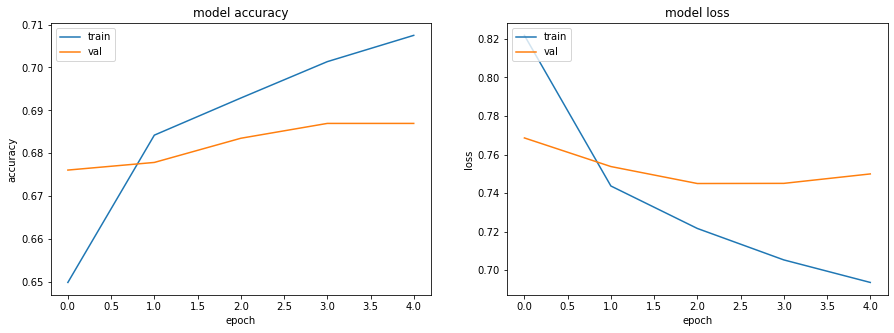

In [80]:
import matplotlib.pyplot as plt

# plot the outcome
fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, sharey = False)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title("model accuracy")
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title("model loss")
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [81]:
display_eval_metrics(my_model, testX, testY, n_ntl_bins)

                  precision    recall  f1-score   support

Radiance Level 1       0.81      0.71      0.75      3420
Radiance Level 2       0.63      0.70      0.66      3429
Radiance Level 3       0.64      0.65      0.65      3268

        accuracy                           0.69     10117
       macro avg       0.69      0.69      0.69     10117
    weighted avg       0.69      0.69      0.69     10117



In [101]:
from tf.keras.utils.plot_model import plot_model
plot_model(my_model, show_shapes=True, show_layer_names=True)

ModuleNotFoundError: No module named 'tf'

In [97]:
kfold = KFold(3, shuffle=True, random_state=1)
# Loop through folds
count = 1
for train_idx, test_idx in kfold.split(DTL):
    print(f'{datetime.datetime.now()}    --- Current K-fold: {count} ---')
    # Select subsets for training and testing
    trainX, trainY, testX, testY = DTL[train_idx], NTL[train_idx], DTL[test_idx], NTL[test_idx]
    
    # PREP TRAINING AND TESTING DATA
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    # PREP PIXELS IN FEATURES
    trainX, testX = normalize(trainX), normalize(testX)
    
    # Pass to evaluate_model function
    es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=False)
    # Save best model based on accuracy
    mc = ModelCheckpoint(CNN_MODEL_CHECKPOINT, monitor='val_loss', mode='min', verbose=True, save_best_only=True)

    # Fit model
    model.fit(trainX, trainY, 
              epochs=100, 
              batch_size=500, 
              validation_data=(testX, testY), 
              callbacks=[es, mc], 
              verbose=False)

    # Show accuracy
    loss, accuracy = model.evaluate(testX, testY, verbose=False)
    print(f' Accuracy: {accuracy}')
    count += 1

2021-05-15 20:48:44.916782    --- Current K-fold: 1 ---


NameError: name 'model' is not defined

## Run Model

In [22]:
model = define_model_imagenet(image_height, image_width, N_bands, n_ntl_bins)

In [23]:
evaluate_model(model, trainX, trainY, testX, testY, CNN_MODEL_CHECKPOINT)


Epoch 00001: val_loss improved from inf to 1.18979, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00002: val_loss improved from 1.18979 to 1.05734, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00003: val_loss improved from 1.05734 to 1.00073, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00004: val_loss improved from 1.00073 to 0.98679, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00005: val_loss did not improve from 0.98679

Epoch 00006: val_loss improved from 0.98679 to 0.96472, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00007: val_loss improved from 0.96472 to 0.96412, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00008: val_loss improved from 0.96412 to 0.95736, saving model to /home/ec2-user/SageMaker/script_CNN_2014_rus.h5

Epoch 00009: val_loss did not improve from 0.95736

Epoch 00010: val_loss improved from 0.95736 to 0.947

In [25]:
# DISPLAY IN-DEPTH EVALUTAION METRICS
best_model = load_model(CNN_MODEL_CHECKPOINT)
display_eval_metrics(model, testX, testY, n_ntl_bins)

                  precision    recall  f1-score   support

Radiance Level 1       0.74      0.78      0.76      5572
Radiance Level 2       0.61      0.73      0.67      5573
Radiance Level 3       0.72      0.55      0.63      5716

        accuracy                           0.69     16861
       macro avg       0.69      0.69      0.68     16861
    weighted avg       0.69      0.69      0.68     16861



## Save Best Model and Predicted Values to s3

In [26]:
## Save predicted values to s3
# TODO: I save file locally then send to s3; might be a way to send df directly to s3

# Predict Values
predY = best_model.predict(testX) # model.predict(testX)
predY = np.argmax(predY, axis = 1)
testY_bins = np.argmax(testY, axis = 1)

# Make Dataframe
results_df = pd.DataFrame({'predY': predY, 'testY': testY_bins})

# Save locally
results_df.to_csv(os.path.join(LOCAL_DIR, PREDICTION_FILENAME), index=False) 

# Send to s3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(CNN_DIR, PREDICTION_FILENAME)).upload_file(os.path.join(LOCAL_DIR, PREDICTION_FILENAME))

In [27]:
## Save best model to s3
boto3.Session().resource('s3').Bucket(bucket).Object(CNN_MODEL_S3_PATH).upload_file(CNN_MODEL_CHECKPOINT)

(300,)

'/home/ec2-user/SageMaker/Pakistan-Poverty-from-Sky/DataWork/03_predict_ntl_with_dtl'